# Strain mapping with py4DSTEM

The code in this directory calculates and visualizes strain maps.

The procedure is divided into 7 steps, each in a single notebook.  This is notebook:
1. Get probe template
2. Get the Bragg disks
3. Determine the diffraction shifts
4. Calculate lattice vectors
5. **Refine lattice vectors**
6. Calculate strain
7. Visualize strain maps

# Notebook 5: Refine lattice vectors

In this step the lattice vectors are refined by performing an interative, weighted fit to the measured Bragg peaks.

* For one, typical diffraction pattern:
    * Get the list of Bragg peaks
    * Determine the Bragg peak indices using the initial u,v guess
    * Iteratively: recalculate u,v values, recalculate Bragg peak indices
    * Get final u,v
* For each diffraction pattern:
    * Get the list of Bragg peaks
    * Ignore if there are insufficient peaks
    * Determine the Bragg peak indices using the initial u,v guess
    * Iteratively: recalculate u,v values, recalculate Bragg peak indices
    * Get final u,v

### Some formalism

The approach here is to iteratively solve the system of linear equations:

\begin{align*}
a \cdot u_x + b \cdot v_x = g^{ab}_x \\
a \cdot u_y + b \cdot v_y = g^{ab}_y
\end{align*}

where $a$ and $b$ are integers which index the diffraction peaks, $\mathbf{u} = u_x\mathbf{\hat{x}} + u_y\mathbf{\hat{y}}$ and $\mathbf{v} = v_x\mathbf{\hat{x}} + v_y\mathbf{\hat{y}}$ are the lattice vectors, $\mathbf{g}^{ab} = g^{ab}_x\mathbf{\hat{x}} + g^{ab}_y\mathbf{\hat{y}}$ is the measured bragg peak at index $(a,b)$, and $\mathbf{\hat{x}}$ and $\mathbf{\hat{y}}$ are orthogonal unit vectors in the diffraction plane.

Equivalently, written as a matrix equation of the form $M\beta = \alpha$:
\begin{equation}
\begin{pmatrix}
&\vdots& \\
a   & &   b   \\
&\vdots&
\end{pmatrix}
\begin{pmatrix}
u_x   &   u_y   \\
v_x   &   v_y
\end{pmatrix}
=
\begin{pmatrix}
&\vdots& \\
g^{ab}_x   & &   g^{ab}_y   \\
&\vdots&
\end{pmatrix}
\end{equation}

Here, $\beta$ is the $2\times2$ lattice vector matrix, $\alpha$ is the $N_{\text{peaks}}\times2$ matrix of measured Bragg peak positions, and $M$ is the $N_{\text{peaks}}\times2$ matrix of Bragg peak indices.

### The approach here

At this point, we have the measured Bragg peak positions $\alpha$, and an initial guess at the lattice vectors $\beta$.

For each diffration pattern, we'll:
* Determine the indices $M$ corresponding to the observed Bragg peak positions, given our initial guess at the lattice vectors.
* Given this matrix of indices $M$ and the measure Bragg peak positions $\alpha$, we'll recalculate the lattice vectors that best the solve system of equations.  This time, we'll weight the importance of each measured Bragg peak position according to its cross correlation intensity.
* Iterate the prior two steps several times

### Import packages, load data

In [89]:
import py4DSTEM

import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage.filters import gaussian_filter
from scipy.optimize import curve_fit
from time import time
from gc import collect
from numpy.linalg import lstsq
from scipy.ndimage.morphology import binary_closing
from scipy.ndimage.filters import maximum_filter

from py4DSTEM.process.datastructure import DataCube, DiffractionSlice, RealSlice, PointList, PointListArray

In [25]:
# Load the raw data
fp = "/Users/Ben/Work/NCEM/Projects/py4DSTEM/sample_data/20180905_FePO4_unlithiated/Stack2_diffraction_shift_corrected.h5"
dc = py4DSTEM.readwrite.read_data(fp)
dc.set_scan_shape(60,60)
dc.data4D = np.roll(dc.data4D,-2,1) # Correct for acquisition wrap-around error

# Load corrected Bragg peaks list
fp_Braggpeaks = "/Users/Ben/Work/NCEM/Projects/py4DSTEM/sample_data/20180905_FePO4_unlithiated/processing/Bragg_disks__shift_corrected.h5"
browser = py4DSTEM.readwrite.FileBrowser(fp_Braggpeaks)
browser.show_dataobjects()
Bragg_peaks = browser.get_dataobject(0)

# Load the lattice vectors
fp_latticevectors = "/Users/Ben/Work/NCEM/Projects/py4DSTEM/sample_data/20180905_FePO4_unlithiated/processing/lattice_vectors.h5"
browser = py4DSTEM.readwrite.FileBrowser(fp_latticevectors)
browser.show_dataobjects()
lattice_vectors = browser.get_dataobject(0)

# Load the deconvolution
fp_deconvolution = "/Users/Ben/Work/NCEM/Projects/py4DSTEM/sample_data/20180905_FePO4_unlithiated/processing/deconvolution.h5"
browser = py4DSTEM.readwrite.FileBrowser(fp_deconvolution)
browser.show_dataobjects()
deconvolution = browser.get_dataobject(0)

Reading file /Users/Ben/Work/NCEM/Projects/py4DSTEM/sample_data/20180905_FePO4_unlithiated/Stack2_diffraction_shift_corrected.h5...

/Users/Ben/Work/NCEM/Projects/py4DSTEM/sample_data/20180905_FePO4_unlithiated/Stack2_diffraction_shift_corrected.h5 is a py4DSTEM HDF5 file.  Reading...
 Index                  Name                        Type        
   0    shifted_Braggpeaks                  PointListArray      
 Index                  Name                        Type        
   0    lattice_vectors                     PointList           
 Index                  Name                        Type        
   0    diffractionslice_0                  DiffractionSlice    


In [26]:
# # Load corrected Bragg peaks list
# fp_Braggpeaks = "/home/ben/Data/20180905_FePO4_unlithiated/processing/Bragg_disks__shift_corrected.h5"
# browser = py4DSTEM.readwrite.FileBrowser(fp_Braggpeaks)
# browser.show_dataobjects()
# Bragg_peaks = browser.get_dataobject(0)

# # Load the raw data
# fp = "/home/ben/Data/20180905_FePO4_unlithiated/h5/Stack2_60x60+30nmss_spot 8_0p05s_CL=600_alpha=0p48_300kV_bin4.h5"
# dc = py4DSTEM.readwrite.read_data_v0_1(fp)
# dc.data4D = np.roll(dc.data4D,-2,1) # Correct for acquisition wrap-around error

# # Load the lattice vectors
# fp_latticevectors = "/home/ben/Data/20180905_FePO4_unlithiated/processing/lattice_vectors.h5"
# browser = py4DSTEM.readwrite.FileBrowser(fp_latticevectors)
# browser.show_dataobjects()
# lattice_vectors = browser.get_dataobject(0)

# # Load the deconvolution
# fp_deconvolution = "/home/ben/Data/20180905_FePO4_unlithiated/processing/deconvolution.h5"
# browser = py4DSTEM.readwrite.FileBrowser(fp_deconvolution)
# browser.show_dataobjects()
# deconvolution = browser.get_dataobject(0)

## Single Diffraction Pattern

In [27]:
# Select DP, get the Bragg peaks for this DP, filter low intensity peaks

rx,ry = 30,30
minRelativeIntensity = 0.02

Bragg_peaks_current_DP = Bragg_peaks.get_pointlist(rx,ry)
deletemask = Bragg_peaks_current_DP.data['intensity']/max(Bragg_peaks_current_DP.data['intensity']) < minRelativeIntensity
Bragg_peaks_current_DP.remove_points(deletemask)

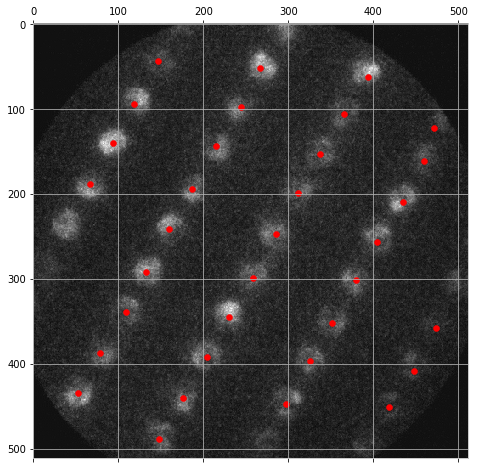

In [28]:
# Show

DP = dc.data4D[ry,rx,:,:]

fig,ax = plt.subplots(figsize=(8,8))
ax.matshow(DP)
ax.scatter(Bragg_peaks_current_DP.data['qy'],Bragg_peaks_current_DP.data['qx'],color='r')
plt.show()

### Determine the Bragg peak indices using the initial u,v guess

In [29]:
# Get the lattice vector matrix (a.k.a. beta)

u_x = lattice_vectors.data['length'][0]*np.cos(lattice_vectors.data['angle'][0]*np.pi/180.)
u_y = lattice_vectors.data['length'][0]*np.sin(lattice_vectors.data['angle'][0]*np.pi/180.)
v_x = lattice_vectors.data['length'][1]*np.cos(lattice_vectors.data['angle'][1]*np.pi/180.)
v_y = lattice_vectors.data['length'][1]*np.sin(lattice_vectors.data['angle'][1]*np.pi/180.)


uv = np.array([[u_x, u_y],[v_x, v_y]])

In [30]:
# Get central peak

x0,y0 = np.unravel_index(np.argmax(deconvolution.data2D),deconvolution.data2D.shape)

ind = np.argmin((Bragg_peaks_current_DP.data['qx']-x0)**2 + (Bragg_peaks_current_DP.data['qy']-y0)**2)
x_beam,y_beam = Bragg_peaks_current_DP.data['qx'][ind],Bragg_peaks_current_DP.data['qy'][ind]

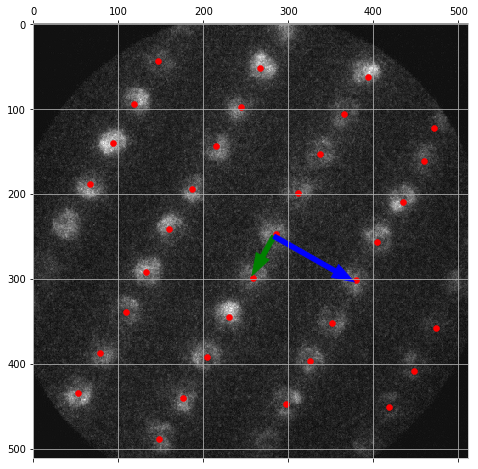

In [31]:
# Show

fig,ax = plt.subplots(figsize=(8,8))
ax.matshow(DP)
ax.scatter(Bragg_peaks_current_DP.data['qy'],Bragg_peaks_current_DP.data['qx'],color='r')
ax.arrow(y0,x0,u_x,u_y, color='green',width=6,length_includes_head=True)
ax.arrow(y0,x0,v_x,v_y, color='blue',width=6,length_includes_head=True)
plt.show()

In [32]:
# Get array of measured Bragg peak positions (a.k.a. alpha), using the central beam as the origin
x = Bragg_peaks_current_DP.data['qx'].reshape(Bragg_peaks_current_DP.length,1) - x_beam
y = Bragg_peaks_current_DP.data['qy'].reshape(Bragg_peaks_current_DP.length,1) - y_beam
Bragg_peak_positions = np.hstack((y,x))

In [33]:
# Get Bragg peak indices

M = lstsq(uv.T, Bragg_peak_positions.T,rcond=None)[0].T
M = np.round(M)

#### A note on solving for $M$ (or: what's up with all the .T's?)
Given an equation of the form $M\beta = \alpha$, the matrix equation solver numpy.linalg.lstsq will solve for $\beta$ given $M$ and $\alpha$.  So when solving for $M$, before passing it to the solver we need to rearrange the matrix equation at the beginning of the notebook as follows:

\begin{equation}
\begin{pmatrix}
u_x   &   v_x   \\
u_y   &   v_y
\end{pmatrix}
\begin{pmatrix}
& a & \\
\ldots   & &   \ldots   \\
&b&
\end{pmatrix}
=
\begin{pmatrix}
& g^{ab}_x & \\
\ldots   & &   \ldots   \\
& g^{ab}_y &
\end{pmatrix}
\end{equation}

Which is equivalent to
\begin{equation}
\beta^T M^T = \alpha^T
\end{equation}
where $A^T$ is the transpose of $A$.

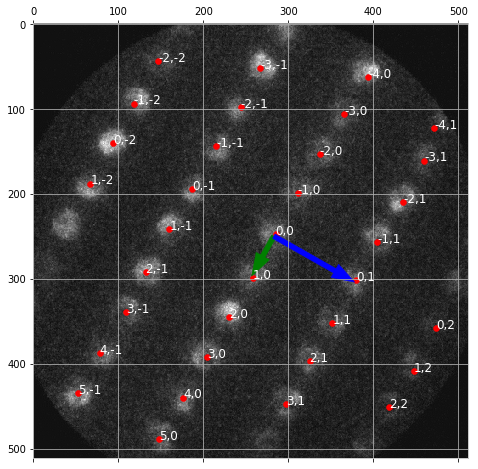

In [34]:
# Show

fig,ax = plt.subplots(figsize=(8,8))
ax.matshow(DP)
ax.scatter(Bragg_peaks_current_DP.data['qy'],Bragg_peaks_current_DP.data['qx'],color='r')
ax.arrow(y0,x0,u_x,u_y, color='green',width=6,length_includes_head=True)
ax.arrow(y0,x0,v_x,v_y, color='blue',width=6,length_includes_head=True)
for i in range(Bragg_peaks_current_DP.length):
    ax.text(Bragg_peaks_current_DP.data['qy'][i],Bragg_peaks_current_DP.data['qx'][i],
            '{},{}'.format(int(M[i,0]),int(M[i,1])),color='w',size=12)
plt.show()

### Refine lattice vectors

In [35]:
iterations = 5

for i in range(5):
    # Add a column for shifting the origin in the coefficient's matrix
    basis = np.column_stack((np.ones(len(M)),M))

    # Get weighted matrices
    weights = Bragg_peaks_current_DP.data['intensity']
    weighted_basis = basis*np.sqrt(weights[:,np.newaxis])
    weighted_Bragg_peak_positions = Bragg_peak_positions*np.sqrt(weights[:,np.newaxis])

    # Solve for lattice vectors (beta)
    beta = lstsq(weighted_basis, weighted_Bragg_peak_positions,rcond=None)[0]

    # Solve for peak indices (M)
    uv = beta[1:,:]
    Bragg_peak_positions_shifted = Bragg_peak_positions-np.tile(beta[0,:],(len(M),1))
    M = lstsq(uv.T, Bragg_peak_positions_shifted.T,rcond=None)[0].T

#### A note on shifting the origin (or: why the extra column in basis, a.k.a. M?)

The final tweak we'll make in the equations we're solving is to additionally fit the origin of the coordinate system.  This is included with the extra parameter $\mathbf{r}^0 = r^0_x\mathbf{\hat{x}} + r^0_y\mathbf{\hat{y}}$ - to wit: 

\begin{align*}
r^0_x + a \cdot u_x + b \cdot v_x = g^{ab}_x \\
r^0_y + a \cdot u_y + b \cdot v_y = g^{ab}_y
\end{align*}

Or, as a matrix equation:
\begin{equation}
\begin{pmatrix}
&\vdots& \\
1 & a   &   b   \\
&\vdots&
\end{pmatrix}
\begin{pmatrix}
r^0_x   &   r^0_y   \\
u_x   &   u_y   \\
v_x   &   v_y
\end{pmatrix}
=
\begin{pmatrix}
&\vdots& \\
g^{ab}_x   & &   g^{ab}_y   \\
&\vdots&
\end{pmatrix}
\end{equation}

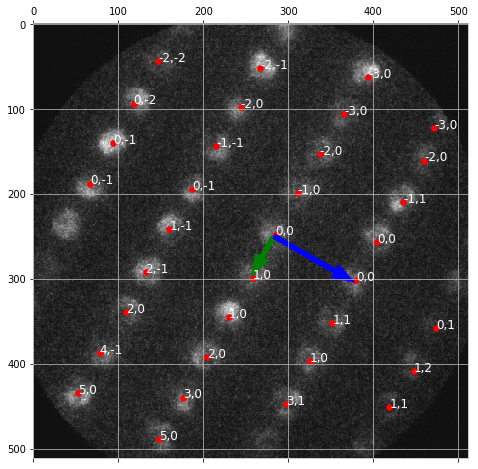

In [36]:
# Show

u_x = uv[0,0]
u_y = uv[0,1]
v_x = uv[1,0]
v_y = uv[1,1]

fig,ax = plt.subplots(figsize=(8,8))
ax.matshow(DP)
ax.scatter(Bragg_peaks_current_DP.data['qy'],Bragg_peaks_current_DP.data['qx'],color='r')
ax.arrow(y0,x0,u_x,u_y, color='green',width=6,length_includes_head=True)
ax.arrow(y0,x0,v_x,v_y, color='blue',width=6,length_includes_head=True)
for i in range(Bragg_peaks_current_DP.length):
    ax.text(Bragg_peaks_current_DP.data['qy'][i],Bragg_peaks_current_DP.data['qx'][i],
            '{},{}'.format(int(M[i,0]),int(M[i,1])),color='w',size=12)
plt.show()

In [37]:
# Calculate the error
basis = np.column_stack((np.ones(len(M)),M))
Bragg_peak_positions_calculated = np.matmul(basis, beta)

fit_error = np.sqrt(np.sum((Bragg_peak_positions - Bragg_peak_positions_calculated)**2,axis=1))
weighted_fit_error = np.sum(fit_error*weights)/np.sum(weights)

## All diffraction patterns 

In [38]:
minRelativeIntensity = 0.02
minNumPeaks = 6
iterations = 5

# Guess at unscattered beam position
x0,y0 = np.unravel_index(np.argmax(deconvolution.data2D),deconvolution.data2D.shape)

# Make containers for outputs
slicelabels = ('ux','uy','vx','vy','fit_error','mask')
uv_map = RealSlice(data=np.zeros((6,dc.R_Ny,dc.R_Nx)),parentDataCube=dc,slicelabels=slicelabels)
DF_image = RealSlice(data=np.zeros((dc.R_Ny,dc.R_Nx)),parentDataCube=dc)

t0=time()
for Ri in range(dc.R_Nx):
    for Rj in range(dc.R_Ny):
        print("Analyzing scan position {},{}".format(Ri,Rj))

        # Get Bragg peaks for current DP
        Bragg_peaks_current_DP = Bragg_peaks.get_pointlist(Ri,Rj)
        deletemask = Bragg_peaks_current_DP.data['intensity']/max(Bragg_peaks_current_DP.data['intensity']) < minRelativeIntensity
        Bragg_peaks_current_DP.remove_points(deletemask)
        
        # Check if minimum number of peaks are present
        if Bragg_peaks_current_DP.length > minNumPeaks:
        
            # Get central peak
            ind = np.argmin((Bragg_peaks_current_DP.data['qx']-x0)**2 + (Bragg_peaks_current_DP.data['qy']-y0)**2)
            x_beam,y_beam= Bragg_peaks_current_DP.data['qx'][ind],Bragg_peaks_current_DP.data['qy'][ind]

            # Get array of measured Bragg peak positions (a.k.a. alpha), using the central beam as the origin
            x = Bragg_peaks_current_DP.data['qx'].reshape(Bragg_peaks_current_DP.length,1) - x_beam
            y = Bragg_peaks_current_DP.data['qy'].reshape(Bragg_peaks_current_DP.length,1) - y_beam
            Bragg_peak_positions = np.hstack((y,x))

            # Get Bragg peak indices
            M = lstsq(uv.T, Bragg_peak_positions.T,rcond=None)[0].T
            M = np.round(M)

            # Refine lattice vectors
            for i in range(5):
                # Add a column for shifting the origin in the coefficient's matrix
                basis = np.column_stack((np.ones(len(M)),M))

                # Get weighted matrices
                weights = Bragg_peaks_current_DP.data['intensity']
                weighted_basis = basis*np.sqrt(weights[:,np.newaxis])
                weighted_Bragg_peak_positions = Bragg_peak_positions*np.sqrt(weights[:,np.newaxis])

                # Solve for lattice vectors (beta)
                beta = lstsq(weighted_basis, weighted_Bragg_peak_positions,rcond=None)[0]

                # Solve for peak indices (M)
                uv = beta[1:,:]
                Bragg_peak_positions_shifted = Bragg_peak_positions-np.tile(beta[0,:],(len(M),1))
                M = lstsq(uv.T, Bragg_peak_positions_shifted.T,rcond=None)[0].T

            # Calculate the error
            basis = np.column_stack((np.ones(len(M)),M))
            Bragg_peak_positions_calculated = np.matmul(basis, beta)

            fit_error = np.sqrt(np.sum((Bragg_peak_positions - Bragg_peak_positions_calculated)**2,axis=1))
            weighted_fit_error = np.sum(fit_error*weights)/np.sum(weights)

            # Store data
            uv_map.data2D['ux'][Rj,Ri] = uv[0,0]
            uv_map.data2D['uy'][Rj,Ri] = uv[0,1]
            uv_map.data2D['vx'][Rj,Ri] = uv[1,0]
            uv_map.data2D['vy'][Rj,Ri] = uv[1,1]
            uv_map.data2D['fit_error'][Rj,Ri] = weighted_fit_error
            DF_image.data2D[Rj,Ri] = np.sum(Bragg_peaks_current_DP.data['intensity'][1:])
        
        # If minimum number of peaks are not present, populate mask
        uv_map.data2D['mask'][Rj,Ri] = 1
        
t=time()-t0
print("Finished in {}h {}m {}s".format(int(t/3600),int(t/60),int(t%60)))

Analyzing scan position 0,0
Analyzing scan position 0,1
Analyzing scan position 0,2
Analyzing scan position 0,3
Analyzing scan position 0,4
Analyzing scan position 0,5
Analyzing scan position 0,6
Analyzing scan position 0,7
Analyzing scan position 0,8
Analyzing scan position 0,9
Analyzing scan position 0,10
Analyzing scan position 0,11
Analyzing scan position 0,12
Analyzing scan position 0,13
Analyzing scan position 0,14
Analyzing scan position 0,15
Analyzing scan position 0,16
Analyzing scan position 0,17
Analyzing scan position 0,18
Analyzing scan position 0,19
Analyzing scan position 0,20
Analyzing scan position 0,21
Analyzing scan position 0,22
Analyzing scan position 0,23
Analyzing scan position 0,24
Analyzing scan position 0,25
Analyzing scan position 0,26
Analyzing scan position 0,27
Analyzing scan position 0,28
Analyzing scan position 0,29
Analyzing scan position 0,30
Analyzing scan position 0,31
Analyzing scan position 0,32
Analyzing scan position 0,33
Analyzing scan position 

Analyzing scan position 12,4
Analyzing scan position 12,5
Analyzing scan position 12,6
Analyzing scan position 12,7
Analyzing scan position 12,8
Analyzing scan position 12,9
Analyzing scan position 12,10
Analyzing scan position 12,11
Analyzing scan position 12,12
Analyzing scan position 12,13
Analyzing scan position 12,14
Analyzing scan position 12,15
Analyzing scan position 12,16
Analyzing scan position 12,17
Analyzing scan position 12,18
Analyzing scan position 12,19
Analyzing scan position 12,20
Analyzing scan position 12,21
Analyzing scan position 12,22
Analyzing scan position 12,23
Analyzing scan position 12,24
Analyzing scan position 12,25
Analyzing scan position 12,26
Analyzing scan position 12,27
Analyzing scan position 12,28
Analyzing scan position 12,29
Analyzing scan position 12,30
Analyzing scan position 12,31
Analyzing scan position 12,32
Analyzing scan position 12,33
Analyzing scan position 12,34
Analyzing scan position 12,35
Analyzing scan position 12,36
Analyzing scan p

Analyzing scan position 18,7
Analyzing scan position 18,8
Analyzing scan position 18,9
Analyzing scan position 18,10
Analyzing scan position 18,11
Analyzing scan position 18,12
Analyzing scan position 18,13
Analyzing scan position 18,14
Analyzing scan position 18,15
Analyzing scan position 18,16
Analyzing scan position 18,17
Analyzing scan position 18,18
Analyzing scan position 18,19
Analyzing scan position 18,20
Analyzing scan position 18,21
Analyzing scan position 18,22
Analyzing scan position 18,23
Analyzing scan position 18,24
Analyzing scan position 18,25
Analyzing scan position 18,26
Analyzing scan position 18,27
Analyzing scan position 18,28
Analyzing scan position 18,29
Analyzing scan position 18,30
Analyzing scan position 18,31
Analyzing scan position 18,32
Analyzing scan position 18,33
Analyzing scan position 18,34
Analyzing scan position 18,35
Analyzing scan position 18,36
Analyzing scan position 18,37
Analyzing scan position 18,38
Analyzing scan position 18,39
Analyzing sca

Analyzing scan position 23,14
Analyzing scan position 23,15
Analyzing scan position 23,16
Analyzing scan position 23,17
Analyzing scan position 23,18
Analyzing scan position 23,19
Analyzing scan position 23,20
Analyzing scan position 23,21
Analyzing scan position 23,22
Analyzing scan position 23,23
Analyzing scan position 23,24
Analyzing scan position 23,25
Analyzing scan position 23,26
Analyzing scan position 23,27
Analyzing scan position 23,28
Analyzing scan position 23,29
Analyzing scan position 23,30
Analyzing scan position 23,31
Analyzing scan position 23,32
Analyzing scan position 23,33
Analyzing scan position 23,34
Analyzing scan position 23,35
Analyzing scan position 23,36
Analyzing scan position 23,37
Analyzing scan position 23,38
Analyzing scan position 23,39
Analyzing scan position 23,40
Analyzing scan position 23,41
Analyzing scan position 23,42
Analyzing scan position 23,43
Analyzing scan position 23,44
Analyzing scan position 23,45
Analyzing scan position 23,46
Analyzing 

Analyzing scan position 30,17
Analyzing scan position 30,18
Analyzing scan position 30,19
Analyzing scan position 30,20
Analyzing scan position 30,21
Analyzing scan position 30,22
Analyzing scan position 30,23
Analyzing scan position 30,24
Analyzing scan position 30,25
Analyzing scan position 30,26
Analyzing scan position 30,27
Analyzing scan position 30,28
Analyzing scan position 30,29
Analyzing scan position 30,30
Analyzing scan position 30,31
Analyzing scan position 30,32
Analyzing scan position 30,33
Analyzing scan position 30,34
Analyzing scan position 30,35
Analyzing scan position 30,36
Analyzing scan position 30,37
Analyzing scan position 30,38
Analyzing scan position 30,39
Analyzing scan position 30,40
Analyzing scan position 30,41
Analyzing scan position 30,42
Analyzing scan position 30,43
Analyzing scan position 30,44
Analyzing scan position 30,45
Analyzing scan position 30,46
Analyzing scan position 30,47
Analyzing scan position 30,48
Analyzing scan position 30,49
Analyzing 

Analyzing scan position 35,4
Analyzing scan position 35,5
Analyzing scan position 35,6
Analyzing scan position 35,7
Analyzing scan position 35,8
Analyzing scan position 35,9
Analyzing scan position 35,10
Analyzing scan position 35,11
Analyzing scan position 35,12
Analyzing scan position 35,13
Analyzing scan position 35,14
Analyzing scan position 35,15
Analyzing scan position 35,16
Analyzing scan position 35,17
Analyzing scan position 35,18
Analyzing scan position 35,19
Analyzing scan position 35,20
Analyzing scan position 35,21
Analyzing scan position 35,22
Analyzing scan position 35,23
Analyzing scan position 35,24
Analyzing scan position 35,25
Analyzing scan position 35,26
Analyzing scan position 35,27
Analyzing scan position 35,28
Analyzing scan position 35,29
Analyzing scan position 35,30
Analyzing scan position 35,31
Analyzing scan position 35,32
Analyzing scan position 35,33
Analyzing scan position 35,34
Analyzing scan position 35,35
Analyzing scan position 35,36
Analyzing scan p

Analyzing scan position 39,38
Analyzing scan position 39,39
Analyzing scan position 39,40
Analyzing scan position 39,41
Analyzing scan position 39,42
Analyzing scan position 39,43
Analyzing scan position 39,44
Analyzing scan position 39,45
Analyzing scan position 39,46
Analyzing scan position 39,47
Analyzing scan position 39,48
Analyzing scan position 39,49
Analyzing scan position 39,50
Analyzing scan position 39,51
Analyzing scan position 39,52
Analyzing scan position 39,53
Analyzing scan position 39,54
Analyzing scan position 39,55
Analyzing scan position 39,56
Analyzing scan position 39,57
Analyzing scan position 39,58
Analyzing scan position 39,59
Analyzing scan position 40,0
Analyzing scan position 40,1
Analyzing scan position 40,2
Analyzing scan position 40,3
Analyzing scan position 40,4
Analyzing scan position 40,5
Analyzing scan position 40,6
Analyzing scan position 40,7
Analyzing scan position 40,8
Analyzing scan position 40,9
Analyzing scan position 40,10
Analyzing scan posit

Analyzing scan position 44,35
Analyzing scan position 44,36
Analyzing scan position 44,37
Analyzing scan position 44,38
Analyzing scan position 44,39
Analyzing scan position 44,40
Analyzing scan position 44,41
Analyzing scan position 44,42
Analyzing scan position 44,43
Analyzing scan position 44,44
Analyzing scan position 44,45
Analyzing scan position 44,46
Analyzing scan position 44,47
Analyzing scan position 44,48
Analyzing scan position 44,49
Analyzing scan position 44,50
Analyzing scan position 44,51
Analyzing scan position 44,52
Analyzing scan position 44,53
Analyzing scan position 44,54
Analyzing scan position 44,55
Analyzing scan position 44,56
Analyzing scan position 44,57
Analyzing scan position 44,58
Analyzing scan position 44,59
Analyzing scan position 45,0
Analyzing scan position 45,1
Analyzing scan position 45,2
Analyzing scan position 45,3
Analyzing scan position 45,4
Analyzing scan position 45,5
Analyzing scan position 45,6
Analyzing scan position 45,7
Analyzing scan pos

Analyzing scan position 49,46
Analyzing scan position 49,47
Analyzing scan position 49,48
Analyzing scan position 49,49
Analyzing scan position 49,50
Analyzing scan position 49,51
Analyzing scan position 49,52
Analyzing scan position 49,53
Analyzing scan position 49,54
Analyzing scan position 49,55
Analyzing scan position 49,56
Analyzing scan position 49,57
Analyzing scan position 49,58
Analyzing scan position 49,59
Analyzing scan position 50,0
Analyzing scan position 50,1
Analyzing scan position 50,2
Analyzing scan position 50,3
Analyzing scan position 50,4
Analyzing scan position 50,5
Analyzing scan position 50,6
Analyzing scan position 50,7
Analyzing scan position 50,8
Analyzing scan position 50,9
Analyzing scan position 50,10
Analyzing scan position 50,11
Analyzing scan position 50,12
Analyzing scan position 50,13
Analyzing scan position 50,14
Analyzing scan position 50,15
Analyzing scan position 50,16
Analyzing scan position 50,17
Analyzing scan position 50,18
Analyzing scan posit

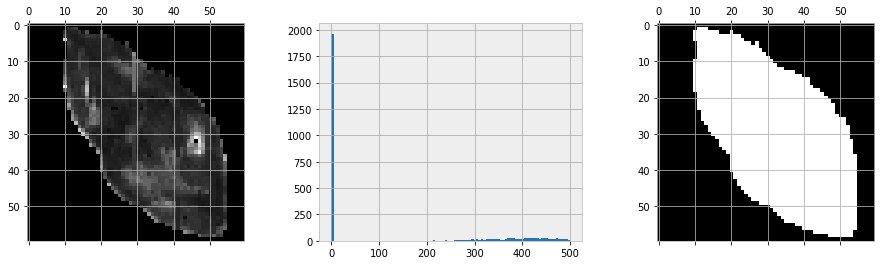

In [66]:
# Make a mask from the virtual dark-field image

mask = (DF_image.data2D>0)
mask = binary_closing(mask_init)

fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(16,4))
ax1.matshow(DF_image.data2D)
ax2.hist(DF_image.data2D.ravel(),bins=np.linspace(0,500,100))
ax3.matshow(mask)
plt.show()

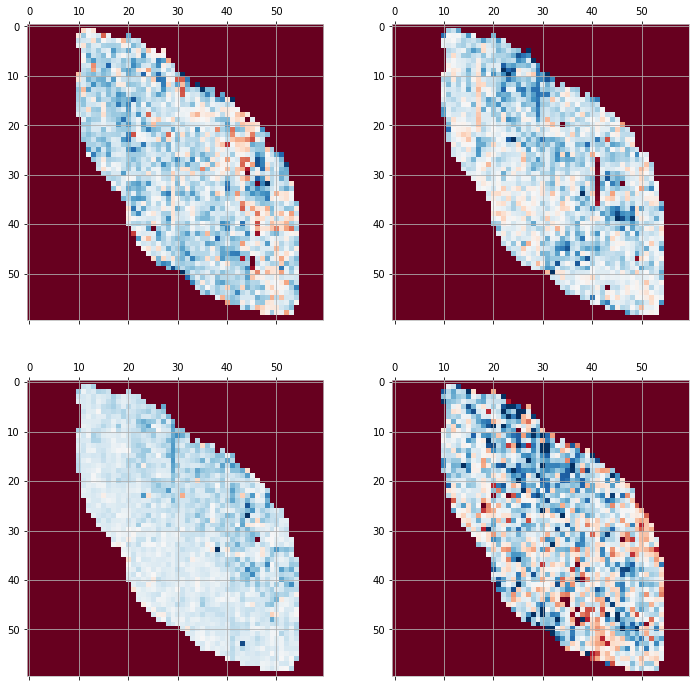

In [102]:
# Plot uncalibrated strains

n_stds = .3

u_lengths = np.sqrt(uv_map.data2D['ux']**2 + uv_map.data2D['uy']**2)
v_lengths = np.sqrt(uv_map.data2D['vx']**2 + uv_map.data2D['vy']**2)
u_length_ave, u_length_std = np.average(u_lengths[mask]), np.std(u_lengths[mask])
v_length_ave, v_length_std = np.average(v_lengths[mask]), np.std(v_lengths[mask])

u_angles = np.angle(uv_map.data2D['ux'] + 1j*uv_map.data2D['uy'])
v_angles = np.angle(uv_map.data2D['vx'] + 1j*uv_map.data2D['vy'])
u_angle_ave, u_angle_std = np.average(u_angles[mask]), np.std(u_angles[mask])
v_angle_ave, v_angle_std = np.average(v_angles[mask]), np.std(v_angles[mask])

fig,((ax11,ax12),(ax21,ax22))=plt.subplots(2,2,figsize=(12,12))
ax11.matshow(u_lengths, vmin=u_length_ave-n_stds*u_length_std, vmax=u_length_ave+n_stds*u_length_std, cmap="RdBu")
ax12.matshow(v_lengths, vmin=v_length_ave-n_stds*v_length_std, vmax=v_length_ave+n_stds*v_length_std, cmap="RdBu")
ax21.matshow(u_angles, vmin=u_angle_ave-n_stds*u_angle_std, vmax=u_angle_ave+n_stds*u_angle_std, cmap="RdBu")
ax22.matshow(v_angles, vmin=v_angle_ave-n_stds*v_angle_std, vmax=v_angle_ave+n_stds*v_angle_std, cmap="RdBu")
plt.show()

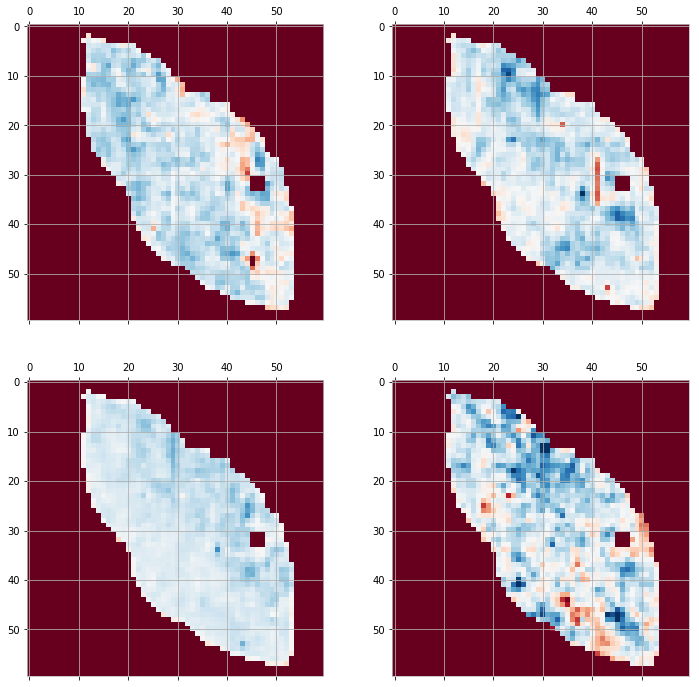

In [103]:
sigma=.6

fig,((ax11,ax12),(ax21,ax22))=plt.subplots(2,2,figsize=(12,12))
ax11.matshow(gaussian_filter(u_lengths,sigma), vmin=u_length_ave-n_stds*u_length_std, vmax=u_length_ave+n_stds*u_length_std, cmap="RdBu")
ax12.matshow(gaussian_filter(v_lengths,sigma), vmin=v_length_ave-n_stds*v_length_std, vmax=v_length_ave+n_stds*v_length_std, cmap="RdBu")
ax21.matshow(gaussian_filter(u_angles,sigma), vmin=u_angle_ave-n_stds*u_angle_std, vmax=u_angle_ave+n_stds*u_angle_std, cmap="RdBu")
ax22.matshow(gaussian_filter(v_angles,sigma), vmin=v_angle_ave-n_stds*v_angle_std, vmax=v_angle_ave+n_stds*v_angle_std, cmap="RdBu")
plt.show()

### Save lattice vector maps

In [185]:
# # Make pointlist

# coordinates = [('angle',float),('length',float)]
# lattice_vectors = PointList(coordinates, dc, name='lattice_vectors')
# lattice_vectors.add_point((u_angle,u_length))
# lattice_vectors.add_point((v_angle,v_length))

In [186]:
# # Save

# savepath = "/home/ben/Data/20180905_FePO4_unlithiated/processing/lattice_vectors.h5"
# py4DSTEM.readwrite.save_dataobject(lattice_vectors,savepath)

Creating file /home/ben/Data/20180905_FePO4_unlithiated/processing/lattice_vectors.h5...
Writing metadata...
Done.


In [187]:
# # Save

# savepath = "/Users/Ben/Work/NCEM/Projects/py4DSTEM/sample_data/20180905_FePO4_unlithiated/processing/lattice_vectors.h5"
# py4DSTEM.readwrite.save_dataobject(lattice_vectors,savepath)